<a href="https://colab.research.google.com/github/Danika-Balas/msds-458/blob/master/PCam_ResNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Introduction

Data is a modified version of the PCam dataset--duplicates have been removed. The goal is to classify the images as cancerous or non-cancerous. A positive label indicates that the center 32x32px region of a patch contains at least one pixel of tumor tissue. Tumor tissue in the outer region of the patch does not influence the label.
https://www.kaggle.com/c/histopathologic-cancer-detection/data?select=train_labels.csv 

###Acknowledgements
Code was adapted from the following sources:

Deep Learning with Python by Francis Chollet

https://www.kaggle.com/gomezp/complete-beginner-s-guide-eda-keras-lb-0-93

https://www.kaggle.com/vbookshelf/cnn-how-to-use-160-000-images-without-crashing

https://www.kaggle.com/artgor/simple-eda-and-model-in-pytorch


#Setup and Preprocessing

In [2]:
import numpy as np
import pandas as pd

import seaborn as sns

import matplotlib.pyplot as plt
#%matplotlib inline
#sns.set(style="whitegrid")

from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, roc_auc_score

import os, random
from random import shuffle
import cv2 #image processing
from glob import glob #for easily finding matching filenames 
from tqdm import tqdm, tqdm_notebook, trange #progress bar
import gc #garbage collection, for saving RAM

import tensorflow as tf
from tensorflow import keras
keras.__version__

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


'2.3.0-tf'

In [3]:
from keras import metrics
from keras import models
from keras import layers

Using TensorFlow backend.


##Upload data

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Code executed once to unzip the files, then commented out:

In [0]:
# #unzip set of training files (smaller dataset to make sure it works)
# !unzip -uq "/content/drive/My Drive/MSDS 458/PCam/sampleTrain.zip" -d "/content/drive/My Drive/MSDS 458/PCam/unzipped/sampleTrain"

In [5]:
#Check whether sample files are readable
sample_names = os.listdir('/content/drive/My Drive/MSDS 458/PCam/unzipped/sampleTrain/sampleTrain')
print(f'{len(sample_names)} files in sample directory')
print(sample_names[:5])

10 files in sample directory
['00a0ad1de2cdf805f02c524a985bca5bce1d1b5f.tif', '0a0a8bdf1d78af77dcc0b94aef6fb5c2f841a3c0.tif', '0a0a2e923bdedb11f270dcd3f11d0f001df98f00.tif', '0a0d1a09e5cf9fcc308ecdc210450aecd204d344.tif', '0a0b4604d66cecfe668e26383c22fafb74484eef.tif']


Started with 10,000 training files in order develop model

Be sure to change path below when adding more files

In [0]:
# #unzip set of training files
# !unzip -uq "/content/drive/My Drive/MSDS 458/PCam/train80P.zip" -d "/content/drive/My Drive/MSDS 458/PCam/unzipped/train"

In [0]:
# drive.mount("/content/drive", force_remount=True)

In [8]:
#Check whether sample files are readable
train_names = os.listdir('/content/drive/My Drive/MSDS 458/PCam/unzipped/train/train80P')
print(f'{len(train_names)} files in training directory')
print(train_names[:5])

80001 files in training directory
['6d1bb57c0606f05dbd75f90a8d9e21a57e1267e0.tif', '9c043ab2adadfeb758c71d21432fccd3e43565c0.tif', '9cc775713dd09351172a350871a547346af08027.tif', '1c1b9b8dc88097d7df41ca9a24111359fd44a57d.tif', '7e45df9e3833b03a4491ef04de755bb04623ab6d.tif']


Code below to unzip testing data. It has not been run yet it order to save space on Drive.

In [0]:
# #unzip set of testing files 
# !unzip -uq "/content/drive/My Drive/MSDS 458/PCam/test.zip" -d "/content/drive/My Drive/MSDS 458/PCam/unzipped/test"

In [0]:
# #Check whether sample files are readable
# test_names = os.listdir('/content/drive/My Drive/MSDS 458/PCam/unzipped/test')
# print(f'{len(test_names)} files in testing directory')
# print(test_names[:5])

##Set paths

In [0]:
path = '/content/drive/My Drive/MSDS 458/PCam/unzipped/'
train_path = path+'train/train80P'
test_path =  path+'test/'
sample_path = path+'sampleTrain/sampleTrain'  #contains 10 images, simply for testing data can be read

##Load labels and filenames

In [0]:
labels = pd.read_csv('/content/drive/My Drive/MSDS 458/PCam/train_labels.csv')

In [13]:
df = pd.DataFrame({'path': glob(os.path.join(train_path,'*.tif'))}) # load the filenames
df['id'] = df.path.map(lambda x: x.split('/')[9].split(".")[0]) # keep only the file names in 'id'
df.head()

,path,id
0,/content/drive/My Drive/MSDS 458/PCam/unzipped...,6d1bb57c0606f05dbd75f90a8d9e21a57e1267e0
1,/content/drive/My Drive/MSDS 458/PCam/unzipped...,9c043ab2adadfeb758c71d21432fccd3e43565c0
2,/content/drive/My Drive/MSDS 458/PCam/unzipped...,9cc775713dd09351172a350871a547346af08027
3,/content/drive/My Drive/MSDS 458/PCam/unzipped...,1c1b9b8dc88097d7df41ca9a24111359fd44a57d
4,/content/drive/My Drive/MSDS 458/PCam/unzipped...,7e45df9e3833b03a4491ef04de755bb04623ab6d


In [0]:
df = df.merge(labels, on = "id") # merge labels and filepaths

In [15]:
df.head(5) # print the first five entries

,path,id,label
0,/content/drive/My Drive/MSDS 458/PCam/unzipped...,6d1bb57c0606f05dbd75f90a8d9e21a57e1267e0,0
1,/content/drive/My Drive/MSDS 458/PCam/unzipped...,9c043ab2adadfeb758c71d21432fccd3e43565c0,1
2,/content/drive/My Drive/MSDS 458/PCam/unzipped...,9cc775713dd09351172a350871a547346af08027,0
3,/content/drive/My Drive/MSDS 458/PCam/unzipped...,1c1b9b8dc88097d7df41ca9a24111359fd44a57d,1
4,/content/drive/My Drive/MSDS 458/PCam/unzipped...,7e45df9e3833b03a4491ef04de755bb04623ab6d,0


In [16]:
print(df.count) #check total number of rows in dataframe

<bound method DataFrame.count of                                                     path  ... label
0      /content/drive/My Drive/MSDS 458/PCam/unzipped...  ...     0
1      /content/drive/My Drive/MSDS 458/PCam/unzipped...  ...     1
2      /content/drive/My Drive/MSDS 458/PCam/unzipped...  ...     0
3      /content/drive/My Drive/MSDS 458/PCam/unzipped...  ...     1
4      /content/drive/My Drive/MSDS 458/PCam/unzipped...  ...     0
...                                                  ...  ...   ...
79995  /content/drive/My Drive/MSDS 458/PCam/unzipped...  ...     0
79996  /content/drive/My Drive/MSDS 458/PCam/unzipped...  ...     0
79997  /content/drive/My Drive/MSDS 458/PCam/unzipped...  ...     0
79998  /content/drive/My Drive/MSDS 458/PCam/unzipped...  ...     1
79999  /content/drive/My Drive/MSDS 458/PCam/unzipped...  ...     1

[80000 rows x 3 columns]>


##Load images

In [0]:
def load_data(N,df):
    """ This functions loads N images using the data df
    """
    # allocate a numpy array for the images (N, 96x96px, 3 channels, values 0 - 255)
    X = np.zeros([N,40,40,3],dtype=np.uint8) 
    #convert the labels to a numpy array too
    dfLabel=df['label']
    y = np.squeeze(dfLabel.to_numpy())[0:N]
    #read images one by one, tdqm notebook displays a progress bar
    for i, row in tqdm_notebook(df.iterrows(), total=N):
        if i == N:
            break
        X[i] = cv2.imread(row['path'])

    # Scale the data to [0,1] interval
    X = X.astype('float16')/255      #comment out to perform EDA steps
    return X,y

In [18]:
# Load some of the images
N=20
X,y = load_data(N=N,df=df) 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # Remove the CWD from sys.path while we load stuff.


##EDA

View some sample images. Non-cancerous samples are labeled 0, and cancerous samples are labeled 1.

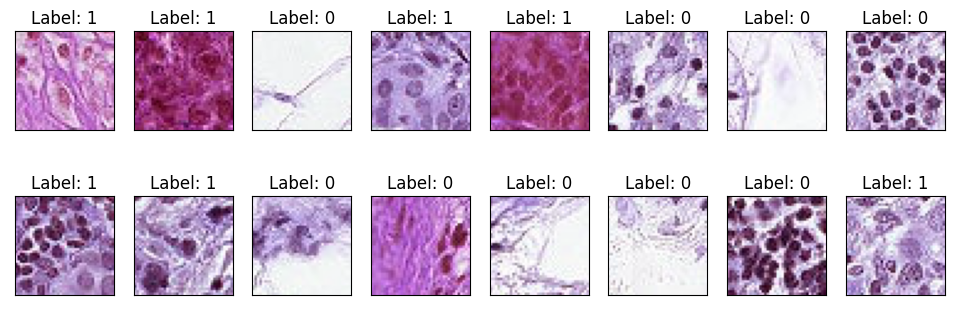

In [22]:
fig = plt.figure(figsize=(12, 4), dpi=100)
np.random.seed(777) #we can use the seed to get a different set of random images
for plotNr,idx in enumerate(np.random.randint(0,N,16)):
    ax = fig.add_subplot(2, 16//2, plotNr+1, xticks=[], yticks=[]) #add subplots
    plt.imshow(X[idx]) #plot image
    ax.set_title('Label: ' + str(y[idx])) #show the label corresponding to the image

Evaluate the distribution of the two classes

Text(0, 0.5, 'Samples')

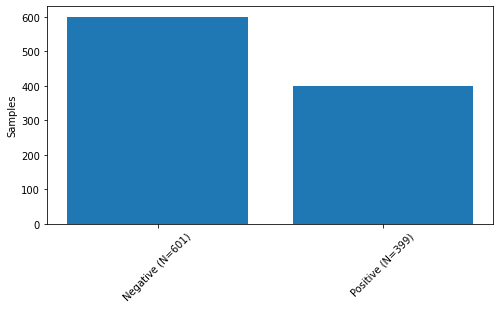

In [23]:
plt.figure(figsize=[8,4])
plt.bar([0,1], [(y==0).sum(), (y==1).sum()])
plt.axis()
plt.xticks([0,1],[f"Negative (N={(y==0).sum()})",f"Positive (N={(y==1).sum()})"],rotation=45)
#plt.xticks(rotation=45)
#plt.rc('xtick',labelsize=10)
plt.ylabel('Samples')


In [24]:
print(f"{round((y==1).sum()/len(y)*100,2)}% of the samples are positive.") 
print(f"We need to clear the baseline of {round((y==0).sum()/len(y)*100,2)}%, which would be the accuracy if we predicted that all of the samples were non-cancerous.")

39.9% of the samples are positive.
We need to clear the baseline of 60.1%, which would be the accuracy if we predicted that all of the samples were non-cancerous.


###To evaluate the classes individually

In [0]:
positive_samples = X[y == 1]
negative_samples = X[y == 0]

Look at the distribution of the pixels for each color channel

In [0]:
# nr_of_bins = 256 #each possible pixel value will get a bin in the following histograms
# fig,axs = plt.subplots(4,2,sharey=True,figsize=(8,8),dpi=150)

# #RGB channels
# axs[0,0].hist(positive_samples[:,:,:,0].flatten(),bins=nr_of_bins,density=True)
# axs[0,1].hist(negative_samples[:,:,:,0].flatten(),bins=nr_of_bins,density=True)
# axs[1,0].hist(positive_samples[:,:,:,1].flatten(),bins=nr_of_bins,density=True)
# axs[1,1].hist(negative_samples[:,:,:,1].flatten(),bins=nr_of_bins,density=True)
# axs[2,0].hist(positive_samples[:,:,:,2].flatten(),bins=nr_of_bins,density=True)
# axs[2,1].hist(negative_samples[:,:,:,2].flatten(),bins=nr_of_bins,density=True)

# #All channels
# axs[3,0].hist(positive_samples.flatten(),bins=nr_of_bins,density=True)
# axs[3,1].hist(negative_samples.flatten(),bins=nr_of_bins,density=True)

# #Set image labels
# axs[0,0].set_title("Positive samples (N =" + str(positive_samples.shape[0]) + ")");
# axs[0,1].set_title("Negative samples (N =" + str(negative_samples.shape[0]) + ")");
# axs[0,1].set_ylabel("Red",rotation='horizontal',labelpad=35,fontsize=12)
# axs[1,1].set_ylabel("Green",rotation='horizontal',labelpad=35,fontsize=12)
# axs[2,1].set_ylabel("Blue",rotation='horizontal',labelpad=35,fontsize=12)
# axs[3,1].set_ylabel("RGB",rotation='horizontal',labelpad=35,fontsize=12)
# for i in range(4):
#     axs[i,0].set_ylabel("Relative frequency")
# axs[3,0].set_xlabel("Pixel value")
# axs[3,1].set_xlabel("Pixel value")
# fig.tight_layout()

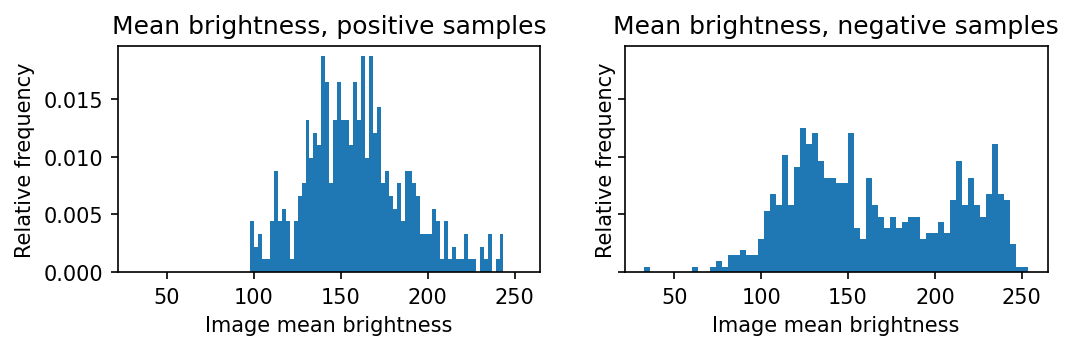

In [27]:
nr_of_bins = 64 #we use a bit fewer bins to get a smoother image
fig,axs = plt.subplots(1,2,sharey=True, sharex = True, figsize=(8,2),dpi=150)
axs[0].hist(np.mean(positive_samples,axis=(1,2,3)),bins=nr_of_bins,density=True);
axs[1].hist(np.mean(negative_samples,axis=(1,2,3)),bins=nr_of_bins,density=True);
axs[0].set_title("Mean brightness, positive samples");
axs[1].set_title("Mean brightness, negative samples");
axs[0].set_xlabel("Image mean brightness")
axs[1].set_xlabel("Image mean brightness")
axs[0].set_ylabel("Relative frequency")
axs[1].set_ylabel("Relative frequency");

In [0]:
#Clean up variables to free up RAM
#Collect garbage
positives_samples = None
negative_samples = None
gc.collect();

#Prepare data for modeling

In [19]:
#Load remainder of dataset
X = None
y = None
gc.collect();
N = df["path"].size # get the number of images in the training data set
X,y = load_data(N=N,df=df)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # Remove the CWD from sys.path while we load stuff.


In [20]:
X[1]

array([[[0.847 , 0.6   , 0.7725],
        [0.965 , 0.7373, 0.9253],
        [0.549 , 0.3254, 0.541 ],
        ...,
        [0.5806, 0.2588, 0.396 ],
        [0.6743, 0.3608, 0.498 ],
        [0.7217, 0.4197, 0.5527]],

       [[0.753 , 0.5293, 0.682 ],
        [0.8354, 0.6235, 0.792 ],
        [0.4941, 0.2783, 0.4707],
        ...,
        [0.686 , 0.3804, 0.541 ],
        [0.392 , 0.1059, 0.2627],
        [0.549 , 0.2705, 0.4275]],

       [[0.949 , 0.7217, 0.859 ],
        [0.9097, 0.702 , 0.855 ],
        [0.604 , 0.396 , 0.569 ],
        ...,
        [0.8076, 0.5254, 0.71  ],
        [0.851 , 0.5884, 0.7646],
        [0.8276, 0.5728, 0.749 ]],

       ...,

       [[0.9688, 0.7334, 0.89  ],
        [0.863 , 0.6274, 0.784 ],
        [0.6704, 0.4275, 0.5845],
        ...,
        [0.7803, 0.51  , 0.655 ],
        [0.8394, 0.5566, 0.7217],
        [0.8037, 0.51  , 0.6904]],

       [[0.8394, 0.608 , 0.757 ],
        [0.6665, 0.4392, 0.5767],
        [0.6904, 0.447 , 0.5884],
        .

##Train test split

In [0]:
# Split into train and test (80/20)
from sklearn.model_selection import train_test_split
#not setting a random_state and not shuffling because samples are already shuffled and want to save RAM 
# added random state instead of shuffle=False
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [22]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((64000, 40, 40, 3), (16000, 40, 40, 3), (64000,), (16000,))

In [0]:
# X = None
# y = None
# gc.collect();

#Define callbacks for training/testing times

In [0]:
# Define callback to get total training time
import datetime

class TrainRuntimeCallback(keras.callbacks.Callback):

  def on_train_begin(self,logs={}):
    self.start = datetime.datetime.now()

  def on_train_end(self,logs={}):
    self.process_time = (datetime.datetime.now() - self.start).total_seconds()

In [0]:
# Define callback to get total test time
import datetime

class TestRuntimeCallback(keras.callbacks.Callback):

  def on_test_begin(self,logs={}):
    self.start = datetime.datetime.now()

  def on_test_end(self,logs={}):
    self.process_time = (datetime.datetime.now() - self.start).total_seconds()

#Experiment 1:DNN
Establish a baseline

##Build and compile the model

In [26]:
model = models.Sequential()

model.add(layers.Flatten(input_shape=(40, 40, 3)))
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 4800)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                48010     
_________________________________________________________________
dropout_1 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 11        
Total params: 48,021
Trainable params: 48,021
Non-trainable params: 0
_________________________________________________________________


In [0]:
model.compile(loss='binary_crossentropy', 
                   optimizer='adam',  
                   metrics=['accuracy'])

##Train the model

In [28]:
train_rt = TrainRuntimeCallback()
history = model.fit(X_train, 
                    y_train,
                    callbacks=[train_rt],
                    epochs=15,
                    batch_size = 100,
                    validation_split = 0.15)

Train on 54400 samples, validate on 9600 samples
Epoch 1/15
54400/54400 [==============================] - 4s 76us/step - loss: 0.6858 - accuracy: 0.5922 - val_loss: 0.6779 - val_accuracy: 0.5892
Epoch 2/15
54400/54400 [==============================] - 4s 71us/step - loss: 0.6755 - accuracy: 0.5946 - val_loss: 0.6772 - val_accuracy: 0.5892
Epoch 3/15
54400/54400 [==============================] - 4s 72us/step - loss: 0.6752 - accuracy: 0.5946 - val_loss: 0.6773 - val_accuracy: 0.5892
Epoch 4/15
54400/54400 [==============================] - 4s 70us/step - loss: 0.6752 - accuracy: 0.5946 - val_loss: 0.6773 - val_accuracy: 0.5892
Epoch 5/15
54400/54400 [==============================] - 4s 70us/step - loss: 0.6752 - accuracy: 0.5946 - val_loss: 0.6772 - val_accuracy: 0.5892
Epoch 6/15
54400/54400 [==============================] - 4s 70us/step - loss: 0.6752 - accuracy: 0.5946 - val_loss: 0.6773 - val_accuracy: 0.5892
Epoch 7/15
54400/54400 [==============================] - 4s 71us/ste

In [29]:
# Get the training time
train_time = train_rt.process_time
train_time # in seconds

57.947176

##Test the model

In [30]:
test_rt = TestRuntimeCallback()
test_loss, test_acc = model.evaluate(X_test, y_test, callbacks=[test_rt])
test_loss, test_acc

16000/16000 [==============================] - 2s 97us/step


(0.6747803089618682, 0.5955625176429749)

In [31]:
test_time = test_rt.process_time
test_time # in seconds

1.560107

###ROC and AUROC

In [0]:
#Generate predicted probabilities for X_test, and calculate FPR and TPR 
y_pred = model.predict(X_test).ravel()
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

In [0]:
auc_keras = auc(fpr, tpr)

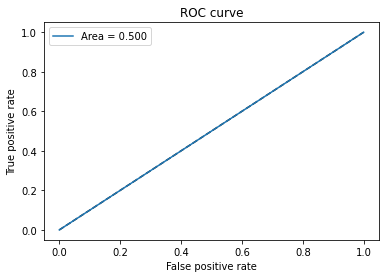

In [34]:
#Plot ROC
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Area = {:.3f}'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

### Create a dataframe for the training and test statistics

In [35]:
history_dict = history.history
history_dict.keys()

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])

In [36]:
history_df=pd.DataFrame(history_dict)
history_df.tail()

,val_loss,val_accuracy,loss,accuracy
10,0.677200,0.589167,0.675153,0.594596
11,0.677214,0.589167,0.675168,0.594596
12,0.677184,0.589167,0.675155,0.594596
13,0.677266,0.589167,0.675158,0.594596
14,0.677196,0.589167,0.675155,0.594596


In [37]:
results_df = history_df.iloc[-1:].copy()
results_df.insert(0,'model','DNN (1 layer)') 
results_df['test_loss'] = test_loss #incorporate test results
results_df['test_accuracy'] = test_acc
results_df['auroc'] = auc_keras
results_df['train time'] = train_time    
results_df['test time'] = test_time    
results_df

,model,val_loss,val_accuracy,loss,accuracy,test_loss,test_accuracy,auroc,train time,test time
14,DNN (1 layer),0.677196,0.589167,0.675155,0.594596,0.67478,0.595563,0.5,57.947176,1.560107


### Plotting the performance 

We use Matplotlib to create 2 plots--displaying the training and validation loss/accuracy for each training epoch side by side.

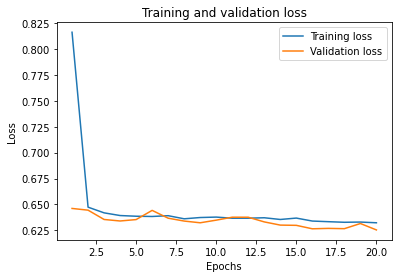

In [61]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

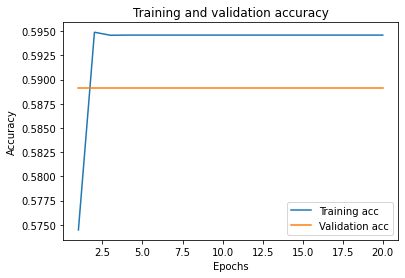

In [62]:
plt.clf()   # clear figure
acc_values = history_dict['accuracy']
# val_acc_values = history_dict['val_acc']

plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.title('Training and validation accuracy')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

#Experiment 2, second DNN

This model is the same as in Experiment 1, but with an additional hidden layer. First hidden layer has 200 nodes, second hidden layer has 100 nodes.

##Build and compile the model

In [84]:
model = models.Sequential()

model.add(layers.Flatten(input_shape=(40, 40, 3)))
model.add(layers.Dense(200, activation='relu'))
model.add(layers.Dense(100, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_5 (Flatten)          (None, 4800)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 200)               960200    
_________________________________________________________________
dense_10 (Dense)             (None, 100)               20100     
_________________________________________________________________
dropout_7 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 101       
Total params: 980,401
Trainable params: 980,401
Non-trainable params: 0
_________________________________________________________________


In [0]:
model.compile(loss='binary_crossentropy', 
                   optimizer='adam',  
                   metrics=['accuracy'])

##Train the model

In [86]:
train_rt = TrainRuntimeCallback()
history = model.fit(X_train, 
                    y_train,
                    callbacks=[train_rt],
                    epochs=20,
                    batch_size = 100,
                    validation_split = 0.15)

Train on 54400 samples, validate on 9600 samples
Epoch 1/20
54400/54400 [==============================] - 5s 95us/step - loss: 0.6714 - accuracy: 0.5898 - val_loss: 0.6319 - val_accuracy: 0.5873
Epoch 2/20
54400/54400 [==============================] - 5s 93us/step - loss: 0.6328 - accuracy: 0.6116 - val_loss: 0.6315 - val_accuracy: 0.6265
Epoch 3/20
54400/54400 [==============================] - 5s 92us/step - loss: 0.6286 - accuracy: 0.6231 - val_loss: 0.6254 - val_accuracy: 0.6698
Epoch 4/20
54400/54400 [==============================] - 5s 94us/step - loss: 0.6235 - accuracy: 0.6311 - val_loss: 0.6304 - val_accuracy: 0.5894
Epoch 5/20
54400/54400 [==============================] - 5s 96us/step - loss: 0.6180 - accuracy: 0.6419 - val_loss: 0.6214 - val_accuracy: 0.6112
Epoch 6/20
54400/54400 [==============================] - 5s 96us/step - loss: 0.6089 - accuracy: 0.6561 - val_loss: 0.6045 - val_accuracy: 0.6624
Epoch 7/20
54400/54400 [==============================] - 5s 92us/ste

In [87]:
# Get the training time
train_time = train_rt.process_time
train_time # in seconds

100.840272

##Test the model

In [88]:
test_rt = TestRuntimeCallback()
test_loss, test_acc = model.evaluate(X_test, y_test, callbacks=[test_rt])
test_loss, test_acc

16000/16000 [==============================] - 2s 102us/step


(0.5879449455738067, 0.6938124895095825)

In [89]:
test_time = test_rt.process_time
test_time # in seconds

1.628008

In [0]:
#Generate predicted probabilities for X_test, and calculate FPR and TPR 
y_pred = model.predict(X_test).ravel()
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

###ROC and AUROC

In [0]:
auc_keras = auc(fpr, tpr)

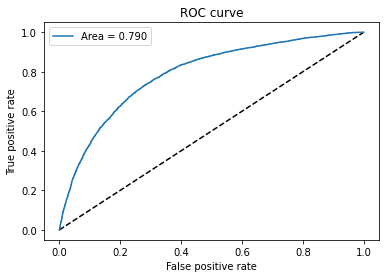

In [92]:
#Plot ROC
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Area = {:.3f}'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

###Add training and test statistics to results dataframe

In [67]:
history_dict = history.history
history_df=pd.DataFrame(history_dict)
df = history_df.iloc[-1:].copy()
df.insert(0,'model','DNN (2 layer dropout)') 
df['test_loss'] = test_loss 
df['test_accuracy'] = test_acc
df['auroc'] = ker
df['train time'] = train_time     
df['test time'] = test_time   
df

,model,val_loss,val_accuracy,loss,accuracy,test_loss,test_accuracy,auroc,train time,test time
19,"DNN (1 layer, D)",0.62548,0.589167,0.632362,0.594596,0.623342,0.595563,0.649822,69.349039,1.669976


In [74]:
results_df=results_df.append(df,ignore_index=True)
results_df


,model,val_loss,val_accuracy,loss,accuracy,test_loss,test_accuracy,auroc,train time,test time
0,"CNN (2 layer, D)",0.414932,0.813125,0.368496,0.840717,0.416671,0.810812,0.889183,153.721501,2.190826
1,"DNN (1 layer, D)",0.625480,0.589167,0.632362,0.594596,0.623342,0.595563,0.649822,69.349039,1.669976


### Plotting the performance 


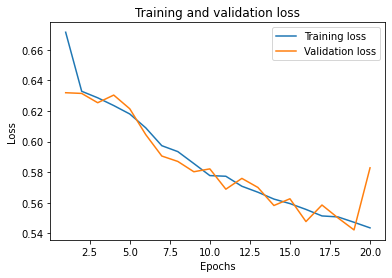

In [93]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

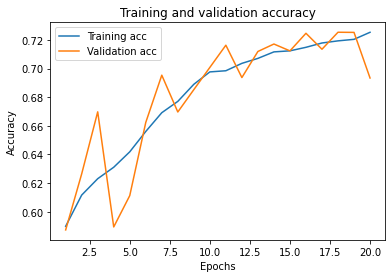

In [94]:
plt.clf()   # clear figure
acc_values = history_dict['accuracy']
# val_acc_values = history_dict['val_acc']

plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.title('Training and validation accuracy')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

#Experiment 3: CNN with 2 convolutional layers

In [54]:
model = models.Sequential()

model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(40, 40, 3)))
model.add(layers.MaxPooling2D((2, 2)))
#model.add(layers.Dropout(0.2))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
#model.add(layers.Dropout(0.2))

model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
#model.add(layers.Dropout(0.2))

model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 38, 38, 32)        896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 19, 19, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 17, 17, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 4096)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 256)               1048832   
_________________________________________________________________
dense_9 (Dense)              (None, 1)                

In [0]:
model.compile(loss='binary_crossentropy', 
                   optimizer='adam',  
                   metrics=['accuracy'])

##Train the model

In [56]:
train_rt = TrainRuntimeCallback()
history = model.fit(X_train, 
                    y_train,
                    callbacks=[train_rt],
                    epochs=15,
                    batch_size = 100,
                    validation_split = 0.15)

Train on 54400 samples, validate on 9600 samples
Epoch 1/15
54400/54400 [==============================] - 10s 188us/step - loss: 0.5214 - accuracy: 0.7446 - val_loss: 0.4841 - val_accuracy: 0.7769
Epoch 2/15
54400/54400 [==============================] - 6s 102us/step - loss: 0.4810 - accuracy: 0.7751 - val_loss: 0.4633 - val_accuracy: 0.7870
Epoch 3/15
54400/54400 [==============================] - 5s 100us/step - loss: 0.4668 - accuracy: 0.7824 - val_loss: 0.4792 - val_accuracy: 0.7735
Epoch 4/15
54400/54400 [==============================] - 5s 101us/step - loss: 0.4529 - accuracy: 0.7933 - val_loss: 0.4537 - val_accuracy: 0.7932
Epoch 5/15
54400/54400 [==============================] - 5s 100us/step - loss: 0.4385 - accuracy: 0.8010 - val_loss: 0.4382 - val_accuracy: 0.8080
Epoch 6/15
54400/54400 [==============================] - 5s 99us/step - loss: 0.4280 - accuracy: 0.8080 - val_loss: 0.4513 - val_accuracy: 0.7920
Epoch 7/15
54400/54400 [==============================] - 6s 10

In [57]:
# Get the training time
train_time = train_rt.process_time
train_time # in seconds

87.033493

##Test the model

In [58]:
test_rt = TestRuntimeCallback()
test_loss, test_acc = model.evaluate(X_test, y_test, callbacks=[test_rt])
test_loss, test_acc

16000/16000 [==============================] - 2s 115us/step


(0.5357609395086765, 0.792062520980835)

In [59]:
test_time = test_rt.process_time
test_time # in seconds

1.846106

###ROC and AUROC

In [0]:
#Generate predicted probabilities for X_test, and calculate FPR and TPR 
y_pred = model.predict(X_test).ravel()
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

In [0]:
auc_keras = auc(fpr, tpr)

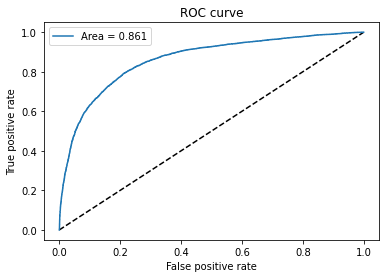

In [66]:
#Plot ROC
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Area = {:.3f}'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

###Add training and test statistics to results dataframe

In [60]:
history_dict = history.history
history_df=pd.DataFrame(history_dict)
df = history_df.iloc[-1:].copy()
df.insert(0,'model','CNN (2 layers)') 
df['test_loss'] = test_loss 
df['test_accuracy'] = test_acc
df['auroc'] = auc_keras
df['train time'] = train_time     
df['test time'] = test_time   
df

,model,val_loss,val_accuracy,loss,accuracy,test_loss,test_accuracy,train time,test time
14,CNN (2 layers),0.523904,0.797708,0.234002,0.907776,0.535761,0.792063,87.033493,1.846106


In [61]:
results_df=results_df.append(df,ignore_index=True)
results_df

,model,val_loss,val_accuracy,loss,accuracy,test_loss,test_accuracy,train time,test time
0,DNN (1 layer),0.588970,0.679271,0.586518,0.689687,0.594717,0.670125,61.349588,1.563415
1,DNN (2 layer dropout),0.567190,0.709271,0.560058,0.709743,0.571902,0.712375,85.752367,1.706699
2,CNN (2 layers),0.523904,0.797708,0.234002,0.907776,0.535761,0.792063,87.033493,1.846106


### Plotting the performance 


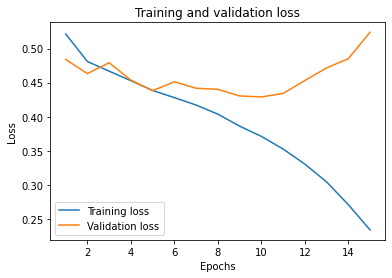

In [62]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

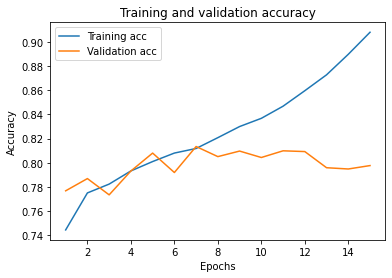

In [63]:
plt.clf()   # clear figure
acc_values = history_dict['accuracy']
# val_acc_values = history_dict['val_acc']

plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.title('Training and validation accuracy')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

#Experiment 4: CNN with 2 convolutional layers, dropout

In [34]:
model = models.Sequential()

model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(40, 40, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.2))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.2))

model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.2))

model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 38, 38, 32)        896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 19, 19, 32)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 19, 19, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 17, 17, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 8, 8, 64)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 4096)             

In [0]:
model.compile(loss='binary_crossentropy', 
                   optimizer='adam',  
                   metrics=['accuracy'])

##Train the model

In [36]:
train_rt = TrainRuntimeCallback()
history = model.fit(X_train, 
                    y_train,
                    callbacks=[train_rt],
                    epochs=15,
                    batch_size = 100,
                    validation_split = 0.15)

Train on 54400 samples, validate on 9600 samples
Epoch 1/15
54400/54400 [==============================] - 15s 267us/step - loss: 0.5324 - accuracy: 0.7378 - val_loss: 0.4903 - val_accuracy: 0.7680
Epoch 2/15
54400/54400 [==============================] - 10s 183us/step - loss: 0.4951 - accuracy: 0.7693 - val_loss: 0.4895 - val_accuracy: 0.7723
Epoch 3/15
54400/54400 [==============================] - 10s 181us/step - loss: 0.4810 - accuracy: 0.7779 - val_loss: 0.4873 - val_accuracy: 0.7777
Epoch 4/15
54400/54400 [==============================] - 10s 182us/step - loss: 0.4665 - accuracy: 0.7878 - val_loss: 0.4734 - val_accuracy: 0.7776
Epoch 5/15
54400/54400 [==============================] - 10s 183us/step - loss: 0.4567 - accuracy: 0.7921 - val_loss: 0.4789 - val_accuracy: 0.7756
Epoch 6/15
54400/54400 [==============================] - 10s 188us/step - loss: 0.4422 - accuracy: 0.8016 - val_loss: 0.4324 - val_accuracy: 0.8058
Epoch 7/15
54400/54400 [==============================] -

In [37]:
# Get the training time
train_time = train_rt.process_time
train_time # in seconds

153.721501

##Test the model

In [38]:
test_rt = TestRuntimeCallback()
test_loss, test_acc = model.evaluate(X_test, y_test, callbacks=[test_rt])
test_loss, test_acc

16000/16000 [==============================] - 2s 137us/step


(0.41667095464468, 0.8108124732971191)

In [39]:
test_time = test_rt.process_time
test_time # in seconds

2.190826

###ROC and AUROC

In [0]:
#Generate predicted probabilities for X_test, and calculate FPR and TPR 
y_pred = model.predict(X_test).ravel()
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

In [0]:
auc_keras = auc(fpr, tpr)

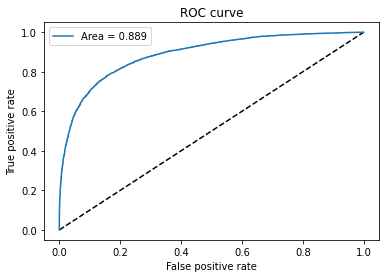

In [42]:
#Plot ROC
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Area = {:.3f}'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

###Add training and test statistics to results dataframe

In [43]:
history_dict = history.history
history_df=pd.DataFrame(history_dict)
df = history_df.iloc[-1:].copy()
df.insert(0,'model','CNN (2 layers, D)') 
df['test_loss'] = test_loss 
df['test_accuracy'] = test_acc
df['auroc'] = auc_keras
df['train time'] = train_time     
df['test time'] = test_time   
df

,model,val_loss,val_accuracy,loss,accuracy,test_loss,test_accuracy,auroc,train time,test time
14,"CNN (2 layers, D)",0.414932,0.813125,0.368496,0.840717,0.416671,0.810812,0.889183,153.721501,2.190826


In [44]:
results_df=results_df.append(df,ignore_index=True)
results_df

,model,val_loss,val_accuracy,loss,accuracy,test_loss,test_accuracy,auroc,train time,test time
0,DNN (1 layer),0.621692,0.589167,0.624048,0.594596,0.619203,0.595563,0.661634,158.144277,1.596417
1,"CNN (2 layers, D)",0.414932,0.813125,0.368496,0.840717,0.416671,0.810812,0.889183,153.721501,2.190826


### Plotting the performance 


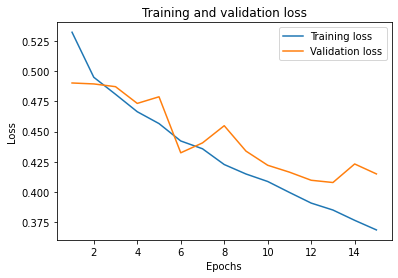

In [45]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

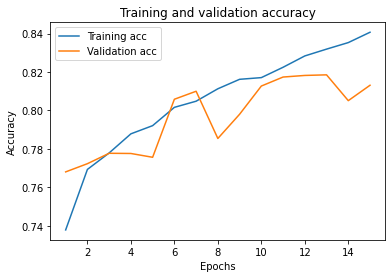

In [46]:
plt.clf()   # clear figure
acc_values = history_dict['accuracy']
# val_acc_values = history_dict['val_acc']

plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.title('Training and validation accuracy')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [0]:
#Export results dataframe

from google.colab import files

results_df.to_csv('PCam80k_pt.csv')
files.download('PCam80k_pt.csv')

#Pre-trained Network: VGG16

In [0]:
from keras.applications import VGG16

## VGG16 3 layers thawed

###Instantiate the model

Do not use dropout initially

In [82]:
from keras.applications import VGG16

conv_base = VGG16(weights = 'imagenet',
                     include_top = False,
                     input_shape = (40, 40, 3))

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))

model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

58892288/58889256 [==============================] - 3s 0us/step
Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 1, 1, 512)         14714688  
_________________________________________________________________
flatten_6 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 257       
Total params: 14,846,273
Trainable params: 14,846,273
Non-trainable params: 0
_________________________________________________________________


Select which layers to freeze during training

In [0]:
# Freeze all but the last three convolutional layers
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [0]:
model.compile(loss='binary_crossentropy', 
                   optimizer='adam',  
                   metrics=['accuracy'])

###Train the model

In [85]:
train_rt = TrainRuntimeCallback()
history = model.fit(X_train, 
                    y_train,
                    callbacks=[train_rt],
                    epochs=15,
                    batch_size = 100,
                    validation_split = 0.15)

Train on 54400 samples, validate on 9600 samples
Epoch 1/15
54400/54400 [==============================] - 17s 310us/step - loss: 0.4729 - accuracy: 0.7848 - val_loss: 0.4289 - val_accuracy: 0.8045
Epoch 2/15
54400/54400 [==============================] - 16s 298us/step - loss: 0.4146 - accuracy: 0.8130 - val_loss: 0.4086 - val_accuracy: 0.8130
Epoch 3/15
54400/54400 [==============================] - 16s 299us/step - loss: 0.3969 - accuracy: 0.8210 - val_loss: 0.3999 - val_accuracy: 0.8195
Epoch 4/15
54400/54400 [==============================] - 16s 298us/step - loss: 0.3754 - accuracy: 0.8327 - val_loss: 0.4004 - val_accuracy: 0.8201
Epoch 5/15
54400/54400 [==============================] - 16s 299us/step - loss: 0.3617 - accuracy: 0.8416 - val_loss: 0.4019 - val_accuracy: 0.8241
Epoch 6/15
54400/54400 [==============================] - 16s 299us/step - loss: 0.3448 - accuracy: 0.8483 - val_loss: 0.4156 - val_accuracy: 0.8181
Epoch 7/15
54400/54400 [==============================] -

In [86]:
# Get the training time
train_time = train_rt.process_time
train_time # in seconds

244.583603

###Test the model

In [87]:
test_rt = TestRuntimeCallback()
test_loss, test_acc = model.evaluate(X_test, y_test, callbacks=[test_rt])
test_loss, test_acc

16000/16000 [==============================] - 5s 308us/step


(0.654116459608078, 0.8091874718666077)

In [88]:
test_time = test_rt.process_time
test_time # in seconds

4.925948

###ROC and AUROC

In [0]:
#Generate predicted probabilities for X_test, and calculate FPR and TPR 
y_pred = model.predict(X_test).ravel()
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

In [0]:
auc_keras = auc(fpr, tpr)

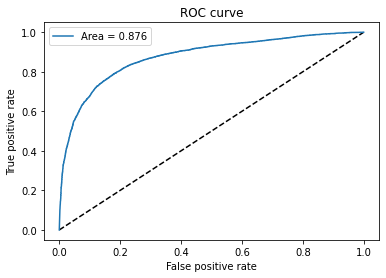

In [95]:
#Plot ROC
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Area = {:.3f}'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

###Add training and test statistics to results dataframe

In [89]:
history_dict = history.history
history_df=pd.DataFrame(history_dict)
df = history_df.iloc[-1:].copy()
df.insert(0,'model','VGG16, 3 thawed') 
df['test_loss'] = test_loss 
df['test_accuracy'] = test_acc
df['auroc'] = auc_keras
df['train time'] = train_time     
df['test time'] = test_time   
df

,model,val_loss,val_accuracy,loss,accuracy,test_loss,test_accuracy,train time,test time
14,"VGG16, 3 thawed",0.651987,0.806562,0.196915,0.917794,0.654116,0.809187,244.583603,4.925948


In [90]:
results_df=results_df.append(df,ignore_index=True)
results_df

,model,val_loss,val_accuracy,loss,accuracy,test_loss,test_accuracy,train time,test time
0,DNN (1 layer),0.588970,0.679271,0.586518,0.689687,0.594717,0.670125,61.349588,1.563415
1,DNN (2 layer dropout),0.567190,0.709271,0.560058,0.709743,0.571902,0.712375,85.752367,1.706699
2,CNN (2 layers),0.523904,0.797708,0.234002,0.907776,0.535761,0.792063,87.033493,1.846106
3,"CNN (2 layers, D)",0.406787,0.817083,0.355217,0.846379,0.404930,0.821875,89.789792,1.926839
4,"VGG16, 3 thawed",0.651987,0.806562,0.196915,0.917794,0.654116,0.809187,244.583603,4.925948


### Plotting the performance 


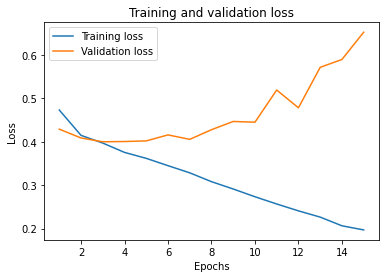

In [91]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

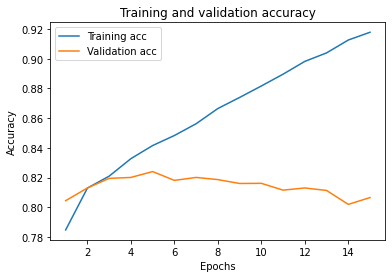

In [92]:
plt.clf()   # clear figure
acc_values = history_dict['accuracy']
# val_acc_values = history_dict['val_acc']

plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.title('Training and validation accuracy')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

##VGG16 3 layers with Dropout

In [96]:
conv_base = VGG16(weights = 'imagenet',
                     include_top = False,
                     input_shape = (40, 40, 3))

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

58892288/58889256 [==============================] - 3s 0us/step
Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 1, 1, 512)         14714688  
_________________________________________________________________
flatten_6 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 256)               131328    
_________________________________________________________________
dropout_8 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 257       
Total params: 14,846,273
Trainable params: 14,846,273
Non-trainable params: 0
_________________________________________________________________


Select which layers to freeze during training

In [0]:
# Freeze all but the last three convolutional layers
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [0]:
model.compile(loss='binary_crossentropy', 
                   optimizer='adam',  
                   metrics=['accuracy'])

###Train the model

In [99]:
train_rt = TrainRuntimeCallback()
history = model.fit(X_train, 
                    y_train,
                    callbacks=[train_rt],
                    epochs=15,
                    batch_size = 100,
                    validation_split = 0.15)

Train on 54400 samples, validate on 9600 samples
Epoch 1/15
54400/54400 [==============================] - 52s 950us/step - loss: 0.4571 - accuracy: 0.7900 - val_loss: 0.4183 - val_accuracy: 0.8080
Epoch 2/15
54400/54400 [==============================] - 50s 927us/step - loss: 0.4112 - accuracy: 0.8165 - val_loss: 0.4132 - val_accuracy: 0.8130
Epoch 3/15
54400/54400 [==============================] - 51s 928us/step - loss: 0.3895 - accuracy: 0.8270 - val_loss: 0.4137 - val_accuracy: 0.8117
Epoch 4/15
54400/54400 [==============================] - 50s 926us/step - loss: 0.3758 - accuracy: 0.8355 - val_loss: 0.4086 - val_accuracy: 0.8159
Epoch 5/15
54400/54400 [==============================] - 51s 929us/step - loss: 0.3603 - accuracy: 0.8444 - val_loss: 0.4146 - val_accuracy: 0.8173
Epoch 6/15
54400/54400 [==============================] - 50s 927us/step - loss: 0.3472 - accuracy: 0.8497 - val_loss: 0.4234 - val_accuracy: 0.8129
Epoch 7/15
54400/54400 [==============================] -

In [100]:
# Get the training time
train_time = train_rt.process_time
train_time # in seconds

757.410375

###Test the model

In [101]:
test_rt = TestRuntimeCallback()
test_loss, test_acc = model.evaluate(X_test, y_test, callbacks=[test_rt])
test_loss, test_acc

16000/16000 [==============================] - 12s 771us/step


(0.6457765243202448, 0.8058750033378601)

In [102]:
test_time = test_rt.process_time
test_time # in seconds

12.342323

###ROC and AUROC

In [0]:
#Generate predicted probabilities for X_test, and calculate FPR and TPR 
y_pred = model.predict(X_test).ravel()
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

In [0]:
auc_keras = auc(fpr, tpr)

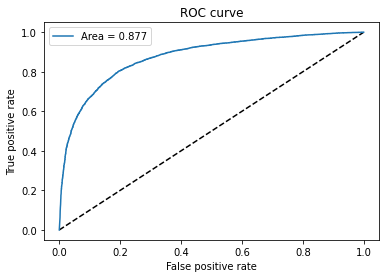

In [105]:
#Plot ROC
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Area = {:.3f}'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

###Add training and test statistics to results dataframe

In [106]:
history_dict = history.history
history_df=pd.DataFrame(history_dict)
df = history_df.iloc[-1:].copy()
df.insert(0,'model','VGG16, 3 thawed, D') 
df['test_loss'] = test_loss 
df['test_accuracy'] = test_acc
df['auroc'] = auc_keras
df['train time'] = train_time     
df['test time'] = test_time   
df

,model,val_loss,val_accuracy,loss,accuracy,test_loss,test_accuracy,auroc,train time,test time
14,"VGG16, 3 thawed, D",0.644842,0.813854,0.21415,0.912132,0.645777,0.805875,0.877119,757.410375,12.342323


In [107]:
results_df=results_df.append(df,ignore_index=True)
results_df

,model,val_loss,val_accuracy,loss,accuracy,test_loss,test_accuracy,auroc,train time,test time
0,"CNN (2 layer, D)",0.414932,0.813125,0.368496,0.840717,0.416671,0.810812,0.889183,153.721501,2.190826
1,"DNN (1 layer, D)",0.625480,0.589167,0.632362,0.594596,0.623342,0.595563,0.649822,69.349039,1.669976
2,"VGG16, 3 thawed, D",0.644842,0.813854,0.214150,0.912132,0.645777,0.805875,0.877119,757.410375,12.342323


### Plotting the performance 


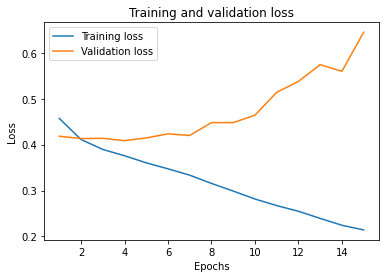

In [108]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

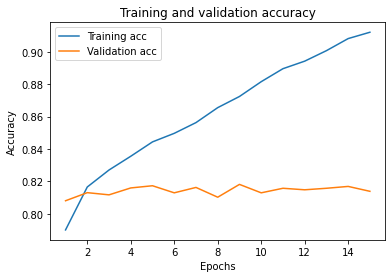

In [109]:
plt.clf()   # clear figure
acc_values = history_dict['accuracy']
# val_acc_values = history_dict['val_acc']

plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.title('Training and validation accuracy')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

##VGG16 unfreeze 6 convolutional layers (block 4 and block 5)

In [110]:
conv_base = VGG16(weights = 'imagenet',
                     include_top = False,
                     input_shape = (40, 40, 3))

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
#model.add(layers.Dropout(0.25))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 1, 1, 512)         14714688  
_________________________________________________________________
flatten_8 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_16 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 257       
Total params: 14,846,273
Trainable params: 14,846,273
Non-trainable params: 0
_________________________________________________________________


Select which layers to freeze during training

In [0]:
# Freeze all but the last three convolutional layers
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block4_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [0]:
model.compile(loss='binary_crossentropy', 
                   optimizer='adam',  
                   metrics=['accuracy'])

###Train the model

In [113]:
train_rt = TrainRuntimeCallback()
history = model.fit(X_train, 
                    y_train,
                    callbacks=[train_rt],
                    epochs=15,
                    batch_size = 100,
                    validation_split = 0.15)

Train on 54400 samples, validate on 9600 samples
Epoch 1/15
54400/54400 [==============================] - 22s 407us/step - loss: 0.4863 - accuracy: 0.7767 - val_loss: 0.4988 - val_accuracy: 0.7557
Epoch 2/15
54400/54400 [==============================] - 22s 398us/step - loss: 0.4218 - accuracy: 0.8118 - val_loss: 0.4002 - val_accuracy: 0.8185
Epoch 3/15
54400/54400 [==============================] - 22s 398us/step - loss: 0.4020 - accuracy: 0.8209 - val_loss: 0.3885 - val_accuracy: 0.8260
Epoch 4/15
54400/54400 [==============================] - 22s 398us/step - loss: 0.4022 - accuracy: 0.8216 - val_loss: 0.3962 - val_accuracy: 0.8196
Epoch 5/15
54400/54400 [==============================] - 22s 398us/step - loss: 0.3877 - accuracy: 0.8284 - val_loss: 0.4211 - val_accuracy: 0.8107
Epoch 6/15
54400/54400 [==============================] - 22s 399us/step - loss: 0.3793 - accuracy: 0.8337 - val_loss: 0.3817 - val_accuracy: 0.8324
Epoch 7/15
54400/54400 [==============================] -

In [114]:
# Get the training time
train_time = train_rt.process_time
train_time # in seconds

325.624062

###Test the model

In [115]:
test_rt = TestRuntimeCallback()
test_loss, test_acc = model.evaluate(X_test, y_test, callbacks=[test_rt])
test_loss, test_acc

16000/16000 [==============================] - 5s 299us/step


(0.40796295475959776, 0.8156874775886536)

In [116]:
test_time = test_rt.process_time
test_time # in seconds

4.787108

###ROC and AUROC

In [0]:
#Generate predicted probabilities for X_test, and calculate FPR and TPR 
y_pred = model.predict(X_test).ravel()
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

In [0]:
auc_keras = auc(fpr, tpr)

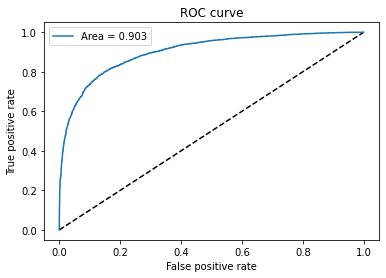

In [124]:
#Plot ROC
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Area = {:.3f}'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

###Add training and test statistics to results dataframe

In [118]:
history_dict = history.history
history_df=pd.DataFrame(history_dict)
df = history_df.iloc[-1:].copy()
df.insert(0,'model','VGG16, 6 thawed') 
df['test_loss'] = test_loss 
df['test_accuracy'] = test_acc
df['auroc'] = auc_keras
df['train time'] = train_time     
df['test time'] = test_time   
df

,model,val_loss,val_accuracy,loss,accuracy,test_loss,test_accuracy,train time,test time
14,"VGG16, 6",0.401944,0.824271,0.326568,0.859651,0.407963,0.815687,325.624062,4.787108


In [119]:
results_df=results_df.append(df,ignore_index=True)
results_df

,model,val_loss,val_accuracy,loss,accuracy,test_loss,test_accuracy,train time,test time
0,DNN (1 layer),0.588970,0.679271,0.586518,0.689687,0.594717,0.670125,61.349588,1.563415
1,DNN (2 layer dropout),0.567190,0.709271,0.560058,0.709743,0.571902,0.712375,85.752367,1.706699
2,CNN (2 layers),0.523904,0.797708,0.234002,0.907776,0.535761,0.792063,87.033493,1.846106
3,"CNN (2 layers, D)",0.406787,0.817083,0.355217,0.846379,0.404930,0.821875,89.789792,1.926839
4,"VGG16, 3 thawed",0.651987,0.806562,0.196915,0.917794,0.654116,0.809187,244.583603,4.925948
5,"VGG16, 3 thawed, D",0.587627,0.803750,0.209187,0.912132,0.583943,0.807375,246.648250,4.863041
6,"VGG16, 6",0.401944,0.824271,0.326568,0.859651,0.407963,0.815687,325.624062,4.787108


### Plotting the performance 


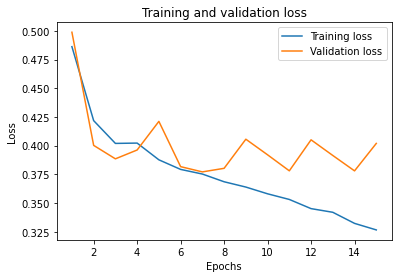

In [120]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

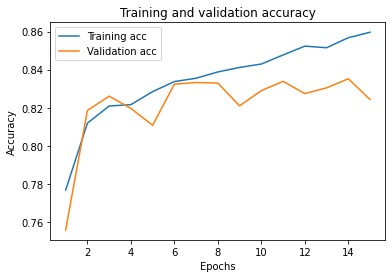

In [121]:
plt.clf()   # clear figure
acc_values = history_dict['accuracy']
# val_acc_values = history_dict['val_acc']

plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.title('Training and validation accuracy')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

##VGG16 unfreeze 6 convolutional layers (block 4 and block 5) with Dropout

In [110]:
conv_base = VGG16(weights = 'imagenet',
                     include_top = False,
                     input_shape = (40, 40, 3))

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.25))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 1, 1, 512)         14714688  
_________________________________________________________________
flatten_7 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 256)               131328    
_________________________________________________________________
dropout_9 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 257       
Total params: 14,846,273
Trainable params: 14,846,273
Non-trainable params: 0
_________________________________________________________________


Select which layers to freeze during training

In [0]:
# Freeze all but the last three convolutional layers
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block4_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [0]:
model.compile(loss='binary_crossentropy', 
                   optimizer='adam',  
                   metrics=['accuracy'])

###Train the model

In [113]:
train_rt = TrainRuntimeCallback()
history = model.fit(X_train, 
                    y_train,
                    callbacks=[train_rt],
                    epochs=15,
                    batch_size = 100,
                    validation_split = 0.15)

Train on 54400 samples, validate on 9600 samples
Epoch 1/15
54400/54400 [==============================] - 72s 1ms/step - loss: 0.5124 - accuracy: 0.7610 - val_loss: 0.4696 - val_accuracy: 0.7892
Epoch 2/15
54400/54400 [==============================] - 71s 1ms/step - loss: 0.4333 - accuracy: 0.8076 - val_loss: 0.4086 - val_accuracy: 0.8147
Epoch 3/15
54400/54400 [==============================] - 71s 1ms/step - loss: 0.4150 - accuracy: 0.8149 - val_loss: 0.4256 - val_accuracy: 0.8058
Epoch 4/15
54400/54400 [==============================] - 71s 1ms/step - loss: 0.3943 - accuracy: 0.8268 - val_loss: 0.4013 - val_accuracy: 0.8156
Epoch 5/15
54400/54400 [==============================] - 71s 1ms/step - loss: 0.3886 - accuracy: 0.8285 - val_loss: 0.3841 - val_accuracy: 0.8263
Epoch 6/15
54400/54400 [==============================] - 71s 1ms/step - loss: 0.3763 - accuracy: 0.8345 - val_loss: 0.3892 - val_accuracy: 0.8241
Epoch 7/15
54400/54400 [==============================] - 70s 1ms/ste

In [114]:
# Get the training time
train_time = train_rt.process_time
train_time # in seconds

1062.310632

###Test the model

In [115]:
test_rt = TestRuntimeCallback()
test_loss, test_acc = model.evaluate(X_test, y_test, callbacks=[test_rt])
test_loss, test_acc

16000/16000 [==============================] - 12s 740us/step


(0.3975109352171421, 0.831125020980835)

In [116]:
test_time = test_rt.process_time
test_time # in seconds

11.847392

###ROC and AUROC

In [0]:
#Generate predicted probabilities for X_test, and calculate FPR and TPR 
y_pred = model.predict(X_test).ravel()
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

In [0]:
auc_keras = auc(fpr, tpr)

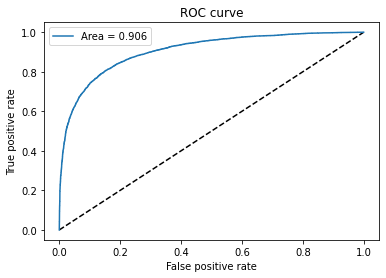

In [119]:
#Plot ROC
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Area = {:.3f}'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

###Add training and test statistics to results dataframe

In [120]:
history_dict = history.history
history_df=pd.DataFrame(history_dict)
df = history_df.iloc[-1:].copy()
df.insert(0,'model','VGG16, 6 thawed D') 
df['test_loss'] = test_loss 
df['test_accuracy'] = test_acc
df['auroc'] = auc_keras
df['train time'] = train_time     
df['test time'] = test_time   
df

,model,val_loss,val_accuracy,loss,accuracy,test_loss,test_accuracy,auroc,train time,test time
14,"VGG16, 6 thawed D",0.396917,0.833854,0.31074,0.868713,0.397511,0.831125,0.905549,1062.310632,11.847392


In [121]:
results_df=results_df.append(df,ignore_index=True)
results_df

,model,val_loss,val_accuracy,loss,accuracy,test_loss,test_accuracy,auroc,train time,test time
0,"CNN (2 layer, D)",0.414932,0.813125,0.368496,0.840717,0.416671,0.810812,0.889183,153.721501,2.190826
1,"DNN (1 layer, D)",0.625480,0.589167,0.632362,0.594596,0.623342,0.595563,0.649822,69.349039,1.669976
2,"VGG16, 3 thawed, D",0.644842,0.813854,0.214150,0.912132,0.645777,0.805875,0.877119,757.410375,12.342323
3,"VGG16, 6 thawed D",0.396917,0.833854,0.310740,0.868713,0.397511,0.831125,0.905549,1062.310632,11.847392


### Plotting the performance 


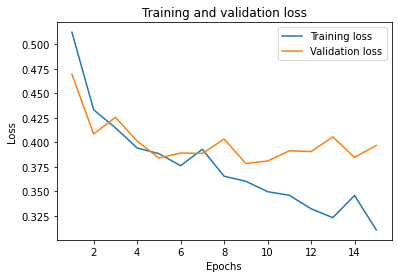

In [122]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

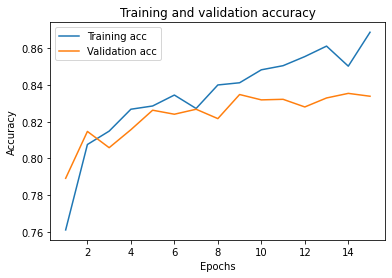

In [123]:
plt.clf()   # clear figure
acc_values = history_dict['accuracy']
# val_acc_values = history_dict['val_acc']

plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.title('Training and validation accuracy')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

##VGG16 unfreeze 9 convolutional layers (blocks 3, 4, 5)

In [124]:
conv_base = VGG16(weights = 'imagenet',
                     include_top = False,
                     input_shape = (40, 40, 3))

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
#model.add(layers.Dropout(0.25))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 1, 1, 512)         14714688  
_________________________________________________________________
flatten_8 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_16 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 257       
Total params: 14,846,273
Trainable params: 14,846,273
Non-trainable params: 0
_________________________________________________________________


Select which layers to freeze during training

In [0]:
# Freeze all but the last three convolutional layers
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block3_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [0]:
model.compile(loss='binary_crossentropy', 
                   optimizer='adam',  
                   metrics=['accuracy'])

###Train the model

In [127]:
train_rt = TrainRuntimeCallback()
history = model.fit(X_train, 
                    y_train,
                    callbacks=[train_rt],
                    epochs=15,
                    batch_size = 100,
                    validation_split = 0.15)

Train on 54400 samples, validate on 9600 samples
Epoch 1/15
54400/54400 [==============================] - 85s 2ms/step - loss: 0.5721 - accuracy: 0.7096 - val_loss: 0.5046 - val_accuracy: 0.7682
Epoch 2/15
54400/54400 [==============================] - 84s 2ms/step - loss: 0.4898 - accuracy: 0.7746 - val_loss: 0.4724 - val_accuracy: 0.7811
Epoch 3/15
54400/54400 [==============================] - 84s 2ms/step - loss: 0.4592 - accuracy: 0.7919 - val_loss: 0.4359 - val_accuracy: 0.8048
Epoch 4/15
54400/54400 [==============================] - 84s 2ms/step - loss: 0.4421 - accuracy: 0.8017 - val_loss: 0.4249 - val_accuracy: 0.8087
Epoch 5/15
54400/54400 [==============================] - 84s 2ms/step - loss: 0.4196 - accuracy: 0.8138 - val_loss: 0.4495 - val_accuracy: 0.8014
Epoch 6/15
54400/54400 [==============================] - 84s 2ms/step - loss: 0.4058 - accuracy: 0.8200 - val_loss: 0.4136 - val_accuracy: 0.8213
Epoch 7/15
54400/54400 [==============================] - 84s 2ms/ste

In [128]:
# Get the training time
train_time = train_rt.process_time
train_time # in seconds

1260.76891

###Test the model

In [129]:
test_rt = TestRuntimeCallback()
test_loss, test_acc = model.evaluate(X_test, y_test, callbacks=[test_rt])
test_loss, test_acc

16000/16000 [==============================] - 12s 727us/step


(0.3753491099178791, 0.8343124985694885)

In [130]:
test_time = test_rt.process_time
test_time # in seconds

11.634572

###ROC and AUROC

In [0]:
#Generate predicted probabilities for X_test, and calculate FPR and TPR 
y_pred = model.predict(X_test).ravel()
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

In [0]:
auc_keras = auc(fpr, tpr)

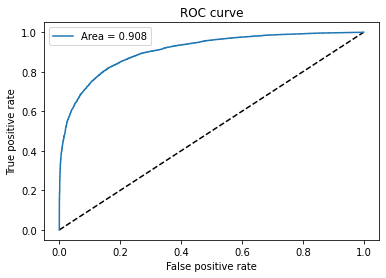

In [133]:
#Plot ROC
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Area = {:.3f}'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

###Add training and test statistics to results dataframe

In [134]:
history_dict = history.history
history_df=pd.DataFrame(history_dict)
df = history_df.iloc[-1:].copy()
df.insert(0,'model','VGG16, 9 thawed') 
df['test_loss'] = test_loss 
df['test_accuracy'] = test_acc
df['auroc'] = auc_keras
df['train time'] = train_time     
df['test time'] = test_time   
df

,model,val_loss,val_accuracy,loss,accuracy,test_loss,test_accuracy,auroc,train time,test time
14,"VGG16, 9 thawed",0.384486,0.836667,0.346331,0.849853,0.375349,0.834312,0.908232,1260.76891,11.634572


In [135]:
results_df=results_df.append(df,ignore_index=True)
results_df

,model,val_loss,val_accuracy,loss,accuracy,test_loss,test_accuracy,auroc,train time,test time
0,"CNN (2 layer, D)",0.414932,0.813125,0.368496,0.840717,0.416671,0.810812,0.889183,153.721501,2.190826
1,"DNN (1 layer, D)",0.625480,0.589167,0.632362,0.594596,0.623342,0.595563,0.649822,69.349039,1.669976
2,"VGG16, 3 thawed, D",0.644842,0.813854,0.214150,0.912132,0.645777,0.805875,0.877119,757.410375,12.342323
3,"VGG16, 6 thawed D",0.396917,0.833854,0.310740,0.868713,0.397511,0.831125,0.905549,1062.310632,11.847392
4,"VGG16, 9 thawed",0.384486,0.836667,0.346331,0.849853,0.375349,0.834312,0.908232,1260.768910,11.634572


### Plotting the performance 


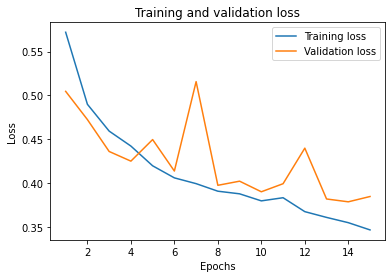

In [136]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

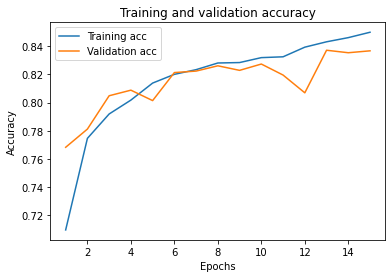

In [137]:
plt.clf()   # clear figure
acc_values = history_dict['accuracy']
# val_acc_values = history_dict['val_acc']

plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.title('Training and validation accuracy')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

##VGG16 unfreeze 9 convolutional layers (blocks 3, 4, 5) with Dropout

In [138]:
conv_base = VGG16(weights = 'imagenet',
                     include_top = False,
                     input_shape = (40, 40, 3))

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.25))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 1, 1, 512)         14714688  
_________________________________________________________________
flatten_9 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_18 (Dense)             (None, 256)               131328    
_________________________________________________________________
dropout_10 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_19 (Dense)             (None, 1)                 257       
Total params: 14,846,273
Trainable params: 14,846,273
Non-trainable params: 0
_________________________________________________________________


Select which layers to freeze during training

In [0]:
# Freeze all but the last three convolutional layers
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block3_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [0]:
model.compile(loss='binary_crossentropy', 
                   optimizer='adam',  
                   metrics=['accuracy'])

###Train the model

In [141]:
train_rt = TrainRuntimeCallback()
history = model.fit(X_train, 
                    y_train,
                    callbacks=[train_rt],
                    epochs=15,
                    batch_size = 100,
                    validation_split = 0.15)

Train on 54400 samples, validate on 9600 samples
Epoch 1/15
54400/54400 [==============================] - 85s 2ms/step - loss: 0.5321 - accuracy: 0.7380 - val_loss: 0.4636 - val_accuracy: 0.7937
Epoch 2/15
54400/54400 [==============================] - 84s 2ms/step - loss: 0.4598 - accuracy: 0.7915 - val_loss: 0.4507 - val_accuracy: 0.7981
Epoch 3/15
54400/54400 [==============================] - 84s 2ms/step - loss: 0.4506 - accuracy: 0.7946 - val_loss: 0.4306 - val_accuracy: 0.8037
Epoch 4/15
54400/54400 [==============================] - 84s 2ms/step - loss: 0.4260 - accuracy: 0.8087 - val_loss: 0.4268 - val_accuracy: 0.8082
Epoch 5/15
54400/54400 [==============================] - 84s 2ms/step - loss: 0.4325 - accuracy: 0.8060 - val_loss: 0.4248 - val_accuracy: 0.8124
Epoch 6/15
54400/54400 [==============================] - 84s 2ms/step - loss: 0.4191 - accuracy: 0.8120 - val_loss: 0.4224 - val_accuracy: 0.8104
Epoch 7/15
54400/54400 [==============================] - 84s 2ms/ste

In [142]:
# Get the training time
train_time = train_rt.process_time
train_time # in seconds

1267.274439

###Test the model

In [143]:
test_rt = TestRuntimeCallback()
test_loss, test_acc = model.evaluate(X_test, y_test, callbacks=[test_rt])
test_loss, test_acc

16000/16000 [==============================] - 12s 744us/step


(0.39206524920463565, 0.8302500247955322)

In [144]:
test_time = test_rt.process_time
test_time # in seconds

11.910122

###ROC and AUROC

In [0]:
#Generate predicted probabilities for X_test, and calculate FPR and TPR 
y_pred = model.predict(X_test).ravel()
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

In [0]:
auc_keras = auc(fpr, tpr)

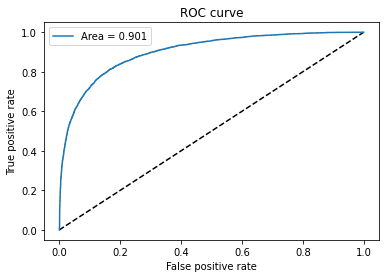

In [147]:
#Plot ROC
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Area = {:.3f}'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

###Add training and test statistics to results dataframe

In [148]:
history_dict = history.history
history_df=pd.DataFrame(history_dict)
df = history_df.iloc[-1:].copy()
df.insert(0,'model','VGG16, 9 thawed') 
df['test_loss'] = test_loss 
df['test_accuracy'] = test_acc
df['auroc'] = auc_keras
df['train time'] = train_time     
df['test time'] = test_time   
df

,model,val_loss,val_accuracy,loss,accuracy,test_loss,test_accuracy,auroc,train time,test time
14,"VGG16, 9 thawed",0.395351,0.828854,0.368661,0.839798,0.392065,0.83025,0.901231,1267.274439,11.910122


In [149]:
results_df=results_df.append(df,ignore_index=True)
results_df

,model,val_loss,val_accuracy,loss,accuracy,test_loss,test_accuracy,auroc,train time,test time
0,"CNN (2 layer, D)",0.414932,0.813125,0.368496,0.840717,0.416671,0.810812,0.889183,153.721501,2.190826
1,"DNN (1 layer, D)",0.625480,0.589167,0.632362,0.594596,0.623342,0.595563,0.649822,69.349039,1.669976
2,"VGG16, 3 thawed, D",0.644842,0.813854,0.214150,0.912132,0.645777,0.805875,0.877119,757.410375,12.342323
3,"VGG16, 6 thawed D",0.396917,0.833854,0.310740,0.868713,0.397511,0.831125,0.905549,1062.310632,11.847392
4,"VGG16, 9 thawed",0.384486,0.836667,0.346331,0.849853,0.375349,0.834312,0.908232,1260.768910,11.634572
5,"VGG16, 9 thawed",0.395351,0.828854,0.368661,0.839798,0.392065,0.830250,0.901231,1267.274439,11.910122


### Plotting the performance 


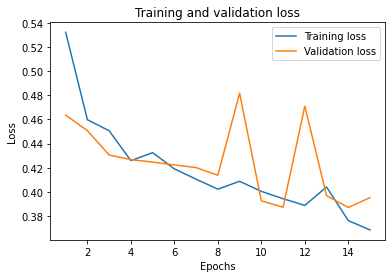

In [150]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

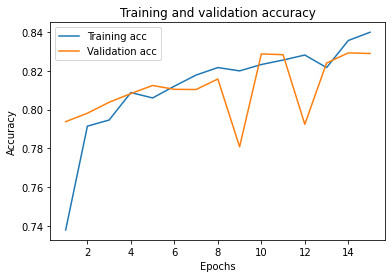

In [151]:
plt.clf()   # clear figure
acc_values = history_dict['accuracy']
# val_acc_values = history_dict['val_acc']

plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.title('Training and validation accuracy')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

#Export results

In [0]:
#Export results dataframe

from google.colab import files

results_df.to_csv('PCam80k_resnet.csv')
files.download('PCam80k_resnet.csv')

#Pre-Trained Network: ResNet

In [0]:
from keras.applications.resnet50 import ResNet50

##ResNet unfreeze last 3 convolutional layers

In [39]:
conv_base = ResNet50(weights = 'imagenet',
                     include_top = False,
                     input_shape = (40,40,3))

model = models.Sequential()

model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
#model.add(layers.Dropout(0.25))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

/usr/local/lib/python3.6/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 2, 2, 2048)        23587712  
_________________________________________________________________
flatten_2 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 257       
Total params: 25,685,377
Trainable params: 25,632,257
Non-trainable params: 53,120
_________________________________________________________________


In [0]:
#To see layers of pre-trained model
# conv_base.summary()



Select which layers to freeze during training

In [0]:
conv_base.Trainable=True

set_trainable=False
for layer in conv_base.layers:
    if layer.name == 'res5c_branch2a':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [0]:
model.compile(loss='binary_crossentropy', 
                   optimizer='adam',  
                   metrics=['accuracy'])

###Train the model

In [43]:
train_rt = TrainRuntimeCallback()
history = model.fit(X_train, 
                    y_train,
                    callbacks=[train_rt],
                    epochs=15,
                    batch_size = 100,
                    validation_split = 0.15)

Train on 54400 samples, validate on 9600 samples
Epoch 1/15
54400/54400 [==============================] - 65s 1ms/step - loss: 0.4507 - accuracy: 0.7997 - val_loss: 4.9863 - val_accuracy: 0.5892
Epoch 2/15
54400/54400 [==============================] - 59s 1ms/step - loss: 0.3720 - accuracy: 0.8350 - val_loss: 0.5846 - val_accuracy: 0.7399
Epoch 3/15
54400/54400 [==============================] - 59s 1ms/step - loss: 0.3223 - accuracy: 0.8595 - val_loss: 0.4223 - val_accuracy: 0.8189
Epoch 4/15
54400/54400 [==============================] - 59s 1ms/step - loss: 0.2625 - accuracy: 0.8913 - val_loss: 0.4664 - val_accuracy: 0.8121
Epoch 5/15
54400/54400 [==============================] - 59s 1ms/step - loss: 0.2000 - accuracy: 0.9195 - val_loss: 0.5267 - val_accuracy: 0.8131
Epoch 6/15
54400/54400 [==============================] - 59s 1ms/step - loss: 0.1548 - accuracy: 0.9403 - val_loss: 0.6058 - val_accuracy: 0.8034
Epoch 7/15
54400/54400 [==============================] - 59s 1ms/ste

In [44]:
# Get the training time
train_time = train_rt.process_time
train_time # in seconds

889.795161

###Test the model

In [45]:
test_rt = TestRuntimeCallback()
test_loss, test_acc = model.evaluate(X_test, y_test, callbacks=[test_rt])
test_loss, test_acc

16000/16000 [==============================] - 20s 1ms/step


(0.9148323074728251, 0.7993124723434448)

In [46]:
test_time = test_rt.process_time
test_time # in seconds

20.129081

###ROC and AUROC

In [0]:
#Generate predicted probabilities for X_test, and calculate FPR and TPR 
y_pred = model.predict(X_test).ravel()
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

In [0]:
auc_keras = auc(fpr, tpr)

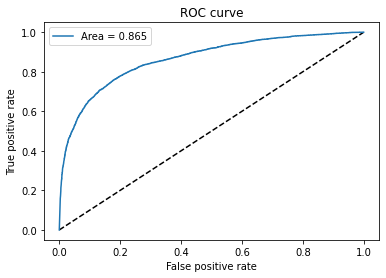

In [49]:
#Plot ROC
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Area = {:.3f}'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

###Add training and test statistics to results dataframe

In [50]:
history_dict = history.history
history_df=pd.DataFrame(history_dict)
df = history_df.iloc[-1:].copy()
df.insert(0,'model','ResNet, 3 thawed') 
df['test_loss'] = test_loss 
df['test_accuracy'] = test_acc
df['auroc'] = auc_keras
df['train time'] = train_time     
df['test time'] = test_time   
df

,model,val_loss,val_accuracy,loss,accuracy,test_loss,test_accuracy,auroc,train time,test time
14,"ResNet, 3 thawed",0.942052,0.810104,0.049807,0.982868,0.914832,0.799312,0.86482,889.795161,20.129081


In [51]:
results_df=results_df.append(df,ignore_index=True)
results_df

,model,val_loss,val_accuracy,loss,accuracy,test_loss,test_accuracy,auroc,train time,test time
0,DNN (1 layer),0.677196,0.589167,0.675155,0.594596,0.674780,0.595563,0.50000,57.947176,1.560107
1,"ResNet, 3 thawed",0.942052,0.810104,0.049807,0.982868,0.914832,0.799312,0.86482,889.795161,20.129081


### Plotting the performance 


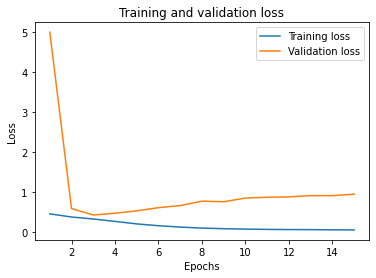

In [52]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

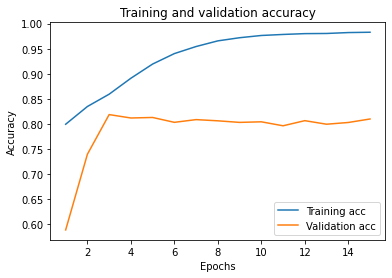

In [53]:
plt.clf()   # clear figure
acc_values = history_dict['accuracy']
# val_acc_values = history_dict['val_acc']

plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.title('Training and validation accuracy')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

##ResNet unfreeze last 3 convolutional layers with Dropout

In [54]:
conv_base = ResNet50(weights = 'imagenet',
                     include_top = False,
                     input_shape = (40,40,3))

model = models.Sequential()

model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.25))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

/usr/local/lib/python3.6/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 2, 2, 2048)        23587712  
_________________________________________________________________
flatten_3 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 257       
Total params: 25,685,377
Trainable params: 25,632,257
Non-trainable params: 53,120
_________________________________________________________________


In [0]:
#To see layers of pre-trained model
# conv_base.summary()



Select which layers to freeze during training

In [0]:
conv_base.Trainable=True

set_trainable=False
for layer in conv_base.layers:
    if layer.name == 'res5c_branch2a':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [0]:
model.compile(loss='binary_crossentropy', 
                   optimizer='adam',  
                   metrics=['accuracy'])

###Train the model

In [58]:
train_rt = TrainRuntimeCallback()
history = model.fit(X_train, 
                    y_train,
                    callbacks=[train_rt],
                    epochs=15,
                    batch_size = 100,
                    validation_split = 0.15)

Train on 54400 samples, validate on 9600 samples
Epoch 1/15
54400/54400 [==============================] - 62s 1ms/step - loss: 0.4602 - accuracy: 0.7966 - val_loss: 3.9703 - val_accuracy: 0.5866
Epoch 2/15
54400/54400 [==============================] - 58s 1ms/step - loss: 0.3835 - accuracy: 0.8319 - val_loss: 0.6200 - val_accuracy: 0.7202
Epoch 3/15
54400/54400 [==============================] - 58s 1ms/step - loss: 0.3408 - accuracy: 0.8529 - val_loss: 0.4252 - val_accuracy: 0.8186
Epoch 4/15
54400/54400 [==============================] - 58s 1ms/step - loss: 0.2921 - accuracy: 0.8766 - val_loss: 0.4452 - val_accuracy: 0.8179
Epoch 5/15
54400/54400 [==============================] - 58s 1ms/step - loss: 0.2467 - accuracy: 0.8988 - val_loss: 0.4926 - val_accuracy: 0.8142
Epoch 6/15
54400/54400 [==============================] - 58s 1ms/step - loss: 0.2004 - accuracy: 0.9217 - val_loss: 0.5400 - val_accuracy: 0.8116
Epoch 7/15
54400/54400 [==============================] - 58s 1ms/ste

In [59]:
# Get the training time
train_time = train_rt.process_time
train_time # in seconds

876.703015

###Test the model

In [60]:
test_rt = TestRuntimeCallback()
test_loss, test_acc = model.evaluate(X_test, y_test, callbacks=[test_rt])
test_loss, test_acc

16000/16000 [==============================] - 20s 1ms/step


(0.8500034713223577, 0.8052499890327454)

In [61]:
test_time = test_rt.process_time
test_time # in seconds

19.645694

###ROC and AUROC

In [0]:
#Generate predicted probabilities for X_test, and calculate FPR and TPR 
y_pred = model.predict(X_test).ravel()
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

In [0]:
auc_keras = auc(fpr, tpr)

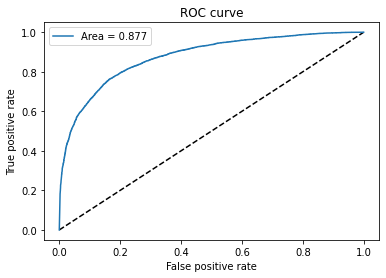

In [64]:
#Plot ROC
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Area = {:.3f}'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

###Add training and test statistics to results dataframe

In [65]:
history_dict = history.history
history_df=pd.DataFrame(history_dict)
df = history_df.iloc[-1:].copy()
df.insert(0,'model','ResNet, 3 thawed D') 
df['test_loss'] = test_loss 
df['test_accuracy'] = test_acc
df['auroc'] = auc_keras
df['train time'] = train_time     
df['test time'] = test_time   
df

,model,val_loss,val_accuracy,loss,accuracy,test_loss,test_accuracy,auroc,train time,test time
14,"ResNet, 3 thawed D",0.865795,0.812708,0.068183,0.975588,0.850003,0.80525,0.876542,876.703015,19.645694


In [66]:
results_df=results_df.append(df,ignore_index=True)
results_df

,model,val_loss,val_accuracy,loss,accuracy,test_loss,test_accuracy,auroc,train time,test time
0,DNN (1 layer),0.677196,0.589167,0.675155,0.594596,0.674780,0.595563,0.500000,57.947176,1.560107
1,"ResNet, 3 thawed",0.942052,0.810104,0.049807,0.982868,0.914832,0.799312,0.864820,889.795161,20.129081
2,"ResNet, 3 thawed D",0.865795,0.812708,0.068183,0.975588,0.850003,0.805250,0.876542,876.703015,19.645694


### Plotting the performance 


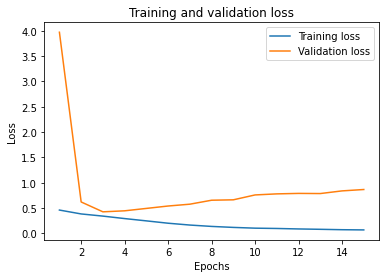

In [67]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

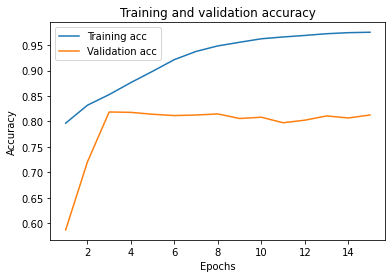

In [68]:
plt.clf()   # clear figure
acc_values = history_dict['accuracy']
# val_acc_values = history_dict['val_acc']

plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.title('Training and validation accuracy')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

##ResNet unfreeze last 6 convolutional layers

In [69]:
conv_base = ResNet50(weights = 'imagenet',
                     include_top = False,
                     input_shape = (40,40,3))

model = models.Sequential()

model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
#model.add(layers.Dropout(0.25))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

/usr/local/lib/python3.6/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 2, 2, 2048)        23587712  
_________________________________________________________________
flatten_4 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 257       
Total params: 25,685,377
Trainable params: 25,632,257
Non-trainable params: 53,120
_________________________________________________________________


In [0]:
#To see layers of pre-trained model
# conv_base.summary()



Select which layers to freeze during training

In [0]:
conv_base.Trainable=True

set_trainable=False
for layer in conv_base.layers:
    if layer.name == 'res5b_branch2a':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [0]:
model.compile(loss='binary_crossentropy', 
                   optimizer='adam',  
                   metrics=['accuracy'])

###Train the model

In [73]:
train_rt = TrainRuntimeCallback()
history = model.fit(X_train, 
                    y_train,
                    callbacks=[train_rt],
                    epochs=15,
                    batch_size = 100,
                    validation_split = 0.15)

Train on 54400 samples, validate on 9600 samples
Epoch 1/15
54400/54400 [==============================] - 72s 1ms/step - loss: 0.4638 - accuracy: 0.8020 - val_loss: 1.2923 - val_accuracy: 0.5882
Epoch 2/15
54400/54400 [==============================] - 68s 1ms/step - loss: 0.3633 - accuracy: 0.8403 - val_loss: 0.7576 - val_accuracy: 0.7028
Epoch 3/15
54400/54400 [==============================] - 67s 1ms/step - loss: 0.3125 - accuracy: 0.8666 - val_loss: 0.4059 - val_accuracy: 0.8285
Epoch 4/15
54400/54400 [==============================] - 67s 1ms/step - loss: 0.2545 - accuracy: 0.8940 - val_loss: 0.4352 - val_accuracy: 0.8192
Epoch 5/15
54400/54400 [==============================] - 67s 1ms/step - loss: 0.1969 - accuracy: 0.9212 - val_loss: 0.4824 - val_accuracy: 0.8160
Epoch 6/15
54400/54400 [==============================] - 67s 1ms/step - loss: 0.1423 - accuracy: 0.9457 - val_loss: 0.5672 - val_accuracy: 0.8156
Epoch 7/15
54400/54400 [==============================] - 67s 1ms/ste

In [74]:
# Get the training time
train_time = train_rt.process_time
train_time # in seconds

1014.917894

###Test the model

In [75]:
test_rt = TestRuntimeCallback()
test_loss, test_acc = model.evaluate(X_test, y_test, callbacks=[test_rt])
test_loss, test_acc

16000/16000 [==============================] - 20s 1ms/step


(0.8988534886538982, 0.807687520980835)

In [76]:
test_time = test_rt.process_time
test_time # in seconds

19.581742

###ROC and AUROC

In [0]:
#Generate predicted probabilities for X_test, and calculate FPR and TPR 
y_pred = model.predict(X_test).ravel()
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

In [0]:
auc_keras = auc(fpr, tpr)

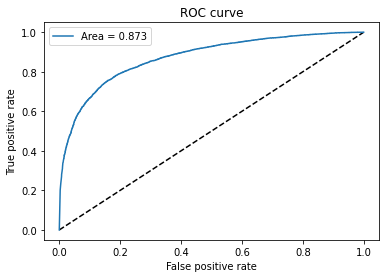

In [79]:
#Plot ROC
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Area = {:.3f}'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

###Add training and test statistics to results dataframe

In [80]:
history_dict = history.history
history_df=pd.DataFrame(history_dict)
df = history_df.iloc[-1:].copy()
df.insert(0,'model','ResNet, 6 thawed D') 
df['test_loss'] = test_loss 
df['test_accuracy'] = test_acc
df['auroc'] = auc_keras
df['train time'] = train_time     
df['test time'] = test_time   
df

,model,val_loss,val_accuracy,loss,accuracy,test_loss,test_accuracy,auroc,train time,test time
14,"ResNet, 6 thawed D",0.88852,0.807292,0.046482,0.984688,0.898853,0.807688,0.872984,1014.917894,19.581742


In [81]:
results_df=results_df.append(df,ignore_index=True)
results_df

,model,val_loss,val_accuracy,loss,accuracy,test_loss,test_accuracy,auroc,train time,test time
0,DNN (1 layer),0.677196,0.589167,0.675155,0.594596,0.674780,0.595563,0.500000,57.947176,1.560107
1,"ResNet, 3 thawed",0.942052,0.810104,0.049807,0.982868,0.914832,0.799312,0.864820,889.795161,20.129081
2,"ResNet, 3 thawed D",0.865795,0.812708,0.068183,0.975588,0.850003,0.805250,0.876542,876.703015,19.645694
3,"ResNet, 6 thawed D",0.888520,0.807292,0.046482,0.984688,0.898853,0.807688,0.872984,1014.917894,19.581742


### Plotting the performance 


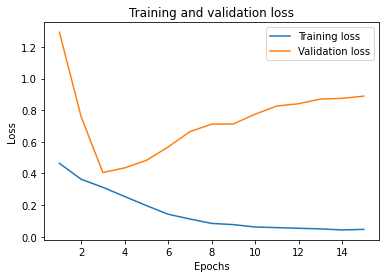

In [82]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

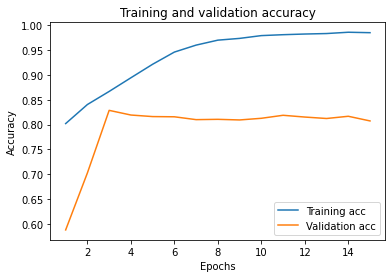

In [83]:
plt.clf()   # clear figure
acc_values = history_dict['accuracy']
# val_acc_values = history_dict['val_acc']

plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.title('Training and validation accuracy')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

##ResNet unfreeze last 6 convolutional layers with Dropout

In [84]:
conv_base = ResNet50(weights = 'imagenet',
                     include_top = False,
                     input_shape = (40,40,3))

model = models.Sequential()

model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.25))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

/usr/local/lib/python3.6/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 2, 2, 2048)        23587712  
_________________________________________________________________
flatten_5 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 257       
Total params: 25,685,377
Trainable params: 25,632,257
Non-trainable params: 53,120
_________________________________________________________________


In [0]:
#To see layers of pre-trained model
# conv_base.summary()



Select which layers to freeze during training

In [0]:
conv_base.Trainable=True

set_trainable=False
for layer in conv_base.layers:
    if layer.name == 'res5b_branch2a':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [0]:
model.compile(loss='binary_crossentropy', 
                   optimizer='adam',  
                   metrics=['accuracy'])

###Train the model

In [88]:
train_rt = TrainRuntimeCallback()
history = model.fit(X_train, 
                    y_train,
                    callbacks=[train_rt],
                    epochs=15,
                    batch_size = 100,
                    validation_split = 0.15)

Train on 54400 samples, validate on 9600 samples
Epoch 1/15
54400/54400 [==============================] - 72s 1ms/step - loss: 0.4776 - accuracy: 0.7982 - val_loss: 0.8199 - val_accuracy: 0.5615
Epoch 2/15
54400/54400 [==============================] - 67s 1ms/step - loss: 0.3786 - accuracy: 0.8356 - val_loss: 0.6531 - val_accuracy: 0.7245
Epoch 3/15
54400/54400 [==============================] - 67s 1ms/step - loss: 0.3372 - accuracy: 0.8539 - val_loss: 0.4077 - val_accuracy: 0.8253
Epoch 4/15
54400/54400 [==============================] - 67s 1ms/step - loss: 0.2889 - accuracy: 0.8773 - val_loss: 0.4369 - val_accuracy: 0.8179
Epoch 5/15
54400/54400 [==============================] - 67s 1ms/step - loss: 0.2411 - accuracy: 0.9005 - val_loss: 0.4858 - val_accuracy: 0.8223
Epoch 6/15
54400/54400 [==============================] - 67s 1ms/step - loss: 0.1938 - accuracy: 0.9232 - val_loss: 0.5248 - val_accuracy: 0.8182
Epoch 7/15
54400/54400 [==============================] - 68s 1ms/ste

In [89]:
# Get the training time
train_time = train_rt.process_time
train_time # in seconds

1016.69099

###Test the model

In [90]:
test_rt = TestRuntimeCallback()
test_loss, test_acc = model.evaluate(X_test, y_test, callbacks=[test_rt])
test_loss, test_acc

16000/16000 [==============================] - 20s 1ms/step


(0.9347213778942823, 0.8103749752044678)

In [91]:
test_time = test_rt.process_time
test_time # in seconds

19.598074

###ROC and AUROC

In [0]:
#Generate predicted probabilities for X_test, and calculate FPR and TPR 
y_pred = model.predict(X_test).ravel()
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

In [0]:
auc_keras = auc(fpr, tpr)

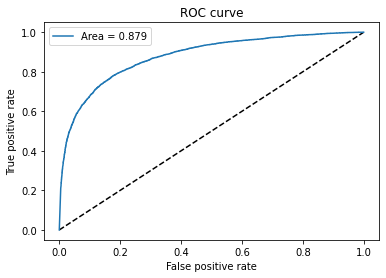

In [94]:
#Plot ROC
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Area = {:.3f}'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

###Add training and test statistics to results dataframe

In [95]:
history_dict = history.history
history_df=pd.DataFrame(history_dict)
df = history_df.iloc[-1:].copy()
df.insert(0,'model','ResNet, 6 thawed D') 
df['test_loss'] = test_loss 
df['test_accuracy'] = test_acc
df['auroc'] = auc_keras
df['train time'] = train_time     
df['test time'] = test_time   
df

,model,val_loss,val_accuracy,loss,accuracy,test_loss,test_accuracy,auroc,train time,test time
14,"ResNet, 6 thawed D",0.887871,0.816146,0.055335,0.981434,0.934721,0.810375,0.879086,1016.69099,19.598074


In [96]:
results_df=results_df.append(df,ignore_index=True)
results_df

,model,val_loss,val_accuracy,loss,accuracy,test_loss,test_accuracy,auroc,train time,test time
0,DNN (1 layer),0.677196,0.589167,0.675155,0.594596,0.674780,0.595563,0.500000,57.947176,1.560107
1,"ResNet, 3 thawed",0.942052,0.810104,0.049807,0.982868,0.914832,0.799312,0.864820,889.795161,20.129081
2,"ResNet, 3 thawed D",0.865795,0.812708,0.068183,0.975588,0.850003,0.805250,0.876542,876.703015,19.645694
3,"ResNet, 6 thawed D",0.888520,0.807292,0.046482,0.984688,0.898853,0.807688,0.872984,1014.917894,19.581742
4,"ResNet, 6 thawed D",0.887871,0.816146,0.055335,0.981434,0.934721,0.810375,0.879086,1016.690990,19.598074


### Plotting the performance 


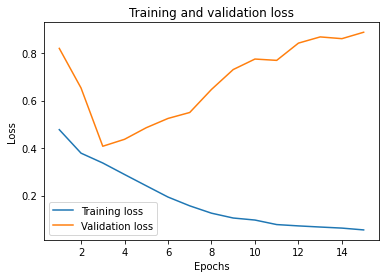

In [97]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

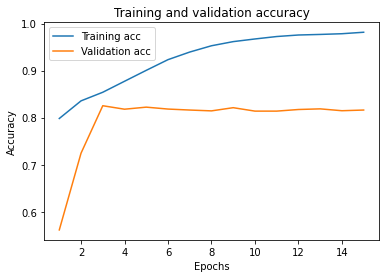

In [98]:
plt.clf()   # clear figure
acc_values = history_dict['accuracy']
# val_acc_values = history_dict['val_acc']

plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.title('Training and validation accuracy')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

##ResNet unfreeze last 9 convolutional layers

In [228]:
conv_base = ResNet50(weights = 'imagenet',
                     include_top = False,
                     input_shape = (40,40,3))

model = models.Sequential()

model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
#model.add(layers.Dropout(0.25))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

/usr/local/lib/python3.6/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 2, 2, 2048)        23587712  
_________________________________________________________________
flatten_15 (Flatten)         (None, 8192)              0         
_________________________________________________________________
dense_30 (Dense)             (None, 256)               2097408   
_________________________________________________________________
dense_31 (Dense)             (None, 1)                 257       
Total params: 25,685,377
Trainable params: 25,632,257
Non-trainable params: 53,120
_________________________________________________________________


In [0]:
#To see layers of pre-trained model
# conv_base.summary()



Select which layers to freeze during training

In [0]:
conv_base.Trainable=True

set_trainable=False
for layer in conv_base.layers:
    if layer.name == 'res5a_branch2b':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [0]:
model.compile(loss='binary_crossentropy', 
                   optimizer='adam',  
                   metrics=['accuracy'])

###Train the model

In [1]:
train_rt = TrainRuntimeCallback()
history = model.fit(X_train, 
                    y_train,
                    callbacks=[train_rt],
                    epochs=10,
                    batch_size = 100,
                    validation_split = 0.15)

NameError: ignored

In [0]:
# Get the training time
train_time = train_rt.process_time
train_time # in seconds

1222.868743

###Test the model

In [0]:
test_rt = TestRuntimeCallback()
test_loss, test_acc = model.evaluate(X_test, y_test, callbacks=[test_rt])
test_loss, test_acc

16000/16000 [==============================] - 20s 1ms/step


(0.9551267297267914, 0.8119375109672546)

In [0]:
test_time = test_rt.process_time
test_time # in seconds

19.751515

###ROC and AUROC

In [0]:
#Generate predicted probabilities for X_test, and calculate FPR and TPR 
y_pred = model.predict(X_test).ravel()
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

In [0]:
auc_keras = auc(fpr, tpr)

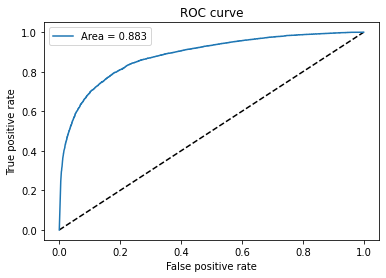

In [0]:
#Plot ROC
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Area = {:.3f}'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

###Add training and test statistics to results dataframe

In [0]:
history_dict = history.history
history_df=pd.DataFrame(history_dict)
df = history_df.iloc[-1:].copy()
df.insert(0,'model','ResNet, 9 thawed D') 
df['test_loss'] = test_loss 
df['test_accuracy'] = test_acc
df['auroc'] = auc_keras
df['train time'] = train_time     
df['test time'] = test_time   
df

,model,val_loss,val_accuracy,loss,accuracy,test_loss,test_accuracy,auroc,train time,test time
14,"ResNet, 3 thawed D",0.968274,0.816146,0.041876,0.98579,0.955127,0.811938,0.883436,1222.868743,19.751515


In [0]:
results_df=results_df.append(df,ignore_index=True)
results_df

,model,val_loss,val_accuracy,loss,accuracy,test_loss,test_accuracy,auroc,train time,test time
0,"CNN (2 layer, D)",0.414932,0.813125,0.368496,0.840717,0.416671,0.810812,0.889183,153.721501,2.190826
1,"DNN (1 layer, D)",0.625480,0.589167,0.632362,0.594596,0.623342,0.595563,0.649822,69.349039,1.669976
2,"VGG16, 3 thawed, D",0.644842,0.813854,0.214150,0.912132,0.645777,0.805875,0.877119,757.410375,12.342323
3,"VGG16, 6 thawed D",0.396917,0.833854,0.310740,0.868713,0.397511,0.831125,0.905549,1062.310632,11.847392
4,"VGG16, 9 thawed",0.384486,0.836667,0.346331,0.849853,0.375349,0.834312,0.908232,1260.768910,11.634572
5,"VGG16, 9 thawed",0.395351,0.828854,0.368661,0.839798,0.392065,0.830250,0.901231,1267.274439,11.910122
6,"ResNet, 3 thawed",0.902344,0.816667,0.038351,0.986746,0.882047,0.816125,0.884676,1225.036565,20.282500
7,"ResNet, 3 thawed D",0.968274,0.816146,0.041876,0.985790,0.955127,0.811938,0.883436,1222.868743,19.751515


### Plotting the performance 


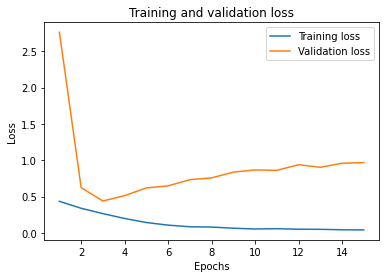

In [0]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

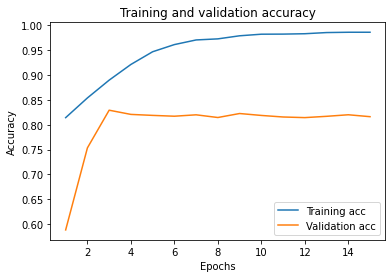

In [0]:
plt.clf()   # clear figure
acc_values = history_dict['accuracy']
# val_acc_values = history_dict['val_acc']

plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.title('Training and validation accuracy')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

#Export results

In [0]:
#Export results dataframe

from google.colab import files

results_df.to_csv('PCam80k_resnet3_6.csv')
files.download('PCam80k_resnet3_6.csv')